In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2
import os
import sys

import clip

import importlib

import contextlib

import json
import os
import random


sys.path.insert(0, os.path.abspath('../..')) 
sys.path.insert(0, os.path.abspath('../../..'))
sys.path.insert(0, os.path.abspath('../../../../stablediffusion'))

In [2]:

import numpy as np
import torch 
from collections import defaultdict
from utils import get_default_path
from utils import Stopwatch
import time
import datetime

In [3]:
import ai.stabledisco as sd
import ai.torchmodules as torchmodules
import ai.torchmodules.data as torchdata
import ai.torchmodules.utils as torchutils
import ai.stabledisco.utils as sdutils
import ai.stabledisco.data as sddata
import ai.stabledisco.constants as sdconsts
import ai.torchmodules.pruning as torchprune
import torch
import torch.nn as nn
import pandas as pd

import ai.stabledisco.decoderpipeline as decoderpipeline
  


torch.multiprocessing.set_start_method('spawn')

In [5]:
tmp_dir =  "/home/ubuntu/tmp/"
tokens_path = os.path.join(tmp_dir, "text_tokens.pk")
rev_tokens_path = os.path.join(tmp_dir, "rev_text_tokens.pk")

df_path = os.path.join("/home/ubuntu/Main/tmp/", "laion_features.feather")
rating_features_path = os.path.join(tmp_dir, "laion_features.pk")
features_path = os.path.join(tmp_dir, "text_features_curr.pk")
tokens_path = os.path.join(tmp_dir, "text_tokens_curr.pk")
rev_tokens_path = os.path.join(tmp_dir, "rev_text_tokens_curr.pk")

features_path_old = os.path.join(tmp_dir, "text_features_old.pk")
tokens_path_old = os.path.join(tmp_dir, "text_tokens_old.pk")
rev_tokens_path_old = os.path.join(tmp_dir, "rev_text_tokens_old.pk")

#prompt_dataframe = pd.read_feather(df_path)


In [ ]:
curr_toks = torch.load(tokens_path)
#old_toks = torch.load(tokens_path_
prompt_dataframe = pd.read_feather(df_path)
rating_tokens = np.array([np.array(toks) for toks in prompt_dataframe["text_tokens"]])
rating_tokens = torch.tensor(rating_tokens)
del prompt_dataframe

In [ ]:

rating_features_path = os.path.join(tmp_dir, "laion_features.pk")
ratings_path = os.path.join(tmp_dir, "laion_ratings.pk")

In [4]:
if len(text_tokens.shape) > 1:
    text_tokens.view(1, text_tokens.size(0))
flipped = torch.flip(text_tokens, dims=(1,))
end_idx_arg = torch.argwhere(flipped == sdconsts.eot_token)[:,1]
for idx in range(flipped.size(0)):
    flipped[idx] = torch.cat((flipped[idx,end_idx_arg[idx]:], flipped[idx,:end_idx_arg[idx]]))


text_tokens = torch.save(flipped, rev_tokens_path)

In [7]:
from ldm.modules.encoders.modules import FrozenOpenCLIPEmbedder
vit14_clip_model = FrozenOpenCLIPEmbedder()
vit14_clip_model = vit14_clip_model.cuda()


In [38]:
from ldm.modules.encoders.modules import FrozenOpenCLIPEmbedder
import open_clip
vit14_clip_model, _,  vit14_clip_preprocess = open_clip.create_model_and_transforms('ViT-H-14', device=torch.device('cuda'), pretrained='laion2b_s32b_b79k')
vit14_clip_model = vit14_clip_model.cuda()

vit14_clip_model = vit14_clip_model.eval()
for param in vit14_clip_model.parameters():
    param.requires_grad = False
    
clip_model = sd.ClipModel(vit14_clip_model, vit14_clip_preprocess, "ViT-H-14").float()

In [45]:
clip_model.cuda()
prompt_features = vit14_clip_model.encode_text(open_clip.tokenize("test this please").cuda())
prompt_features


clip_model.get_features("test this please").cuda()

tensor([[ 0.0288, -0.0193, -0.0392,  ...,  0.0155, -0.0075, -0.0157]],
       device='cuda:0')

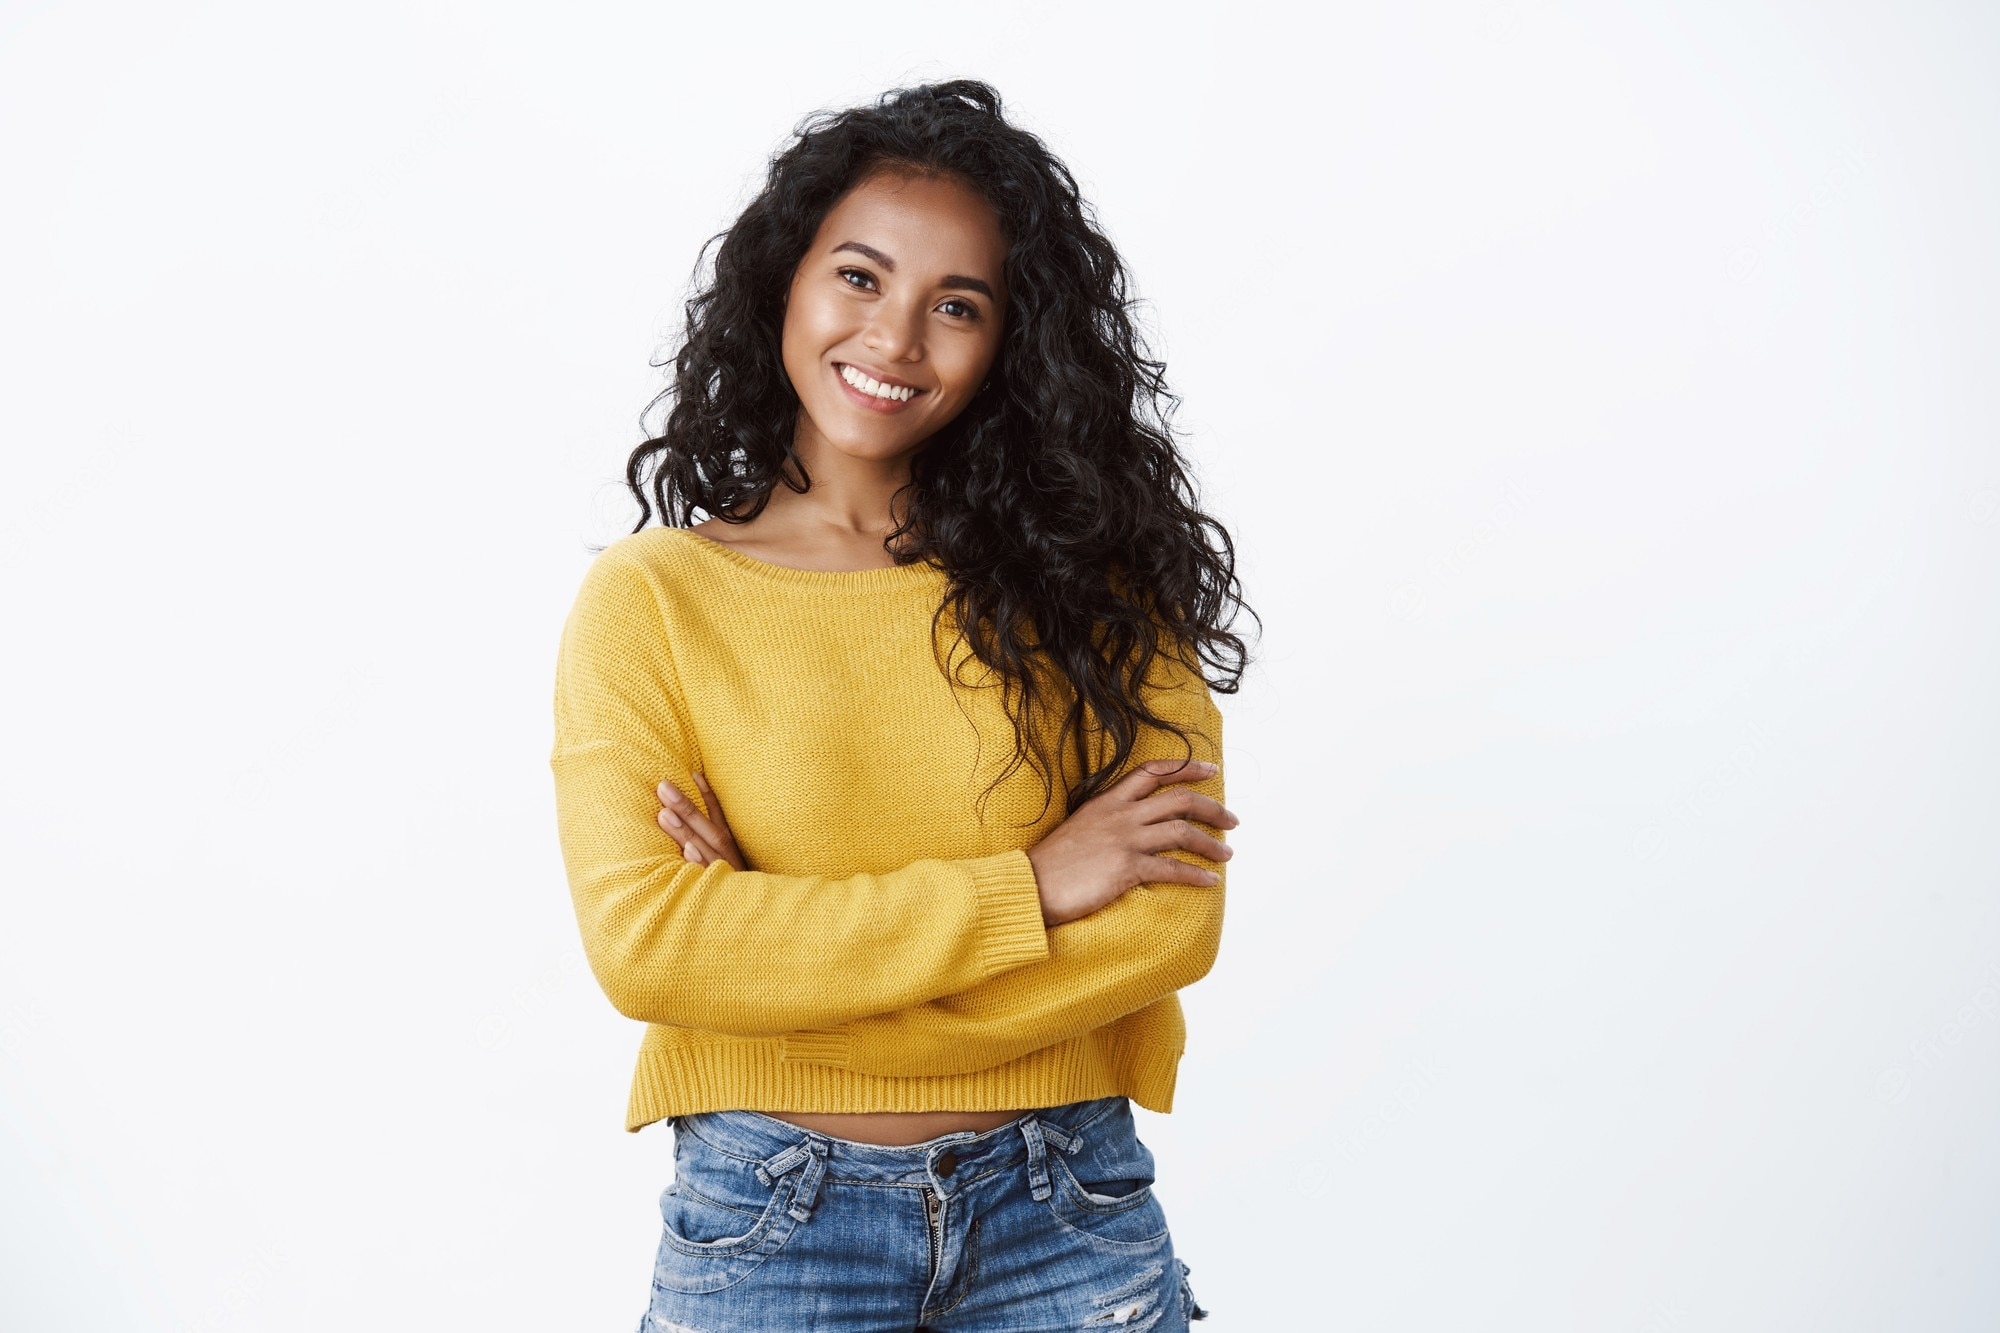

tensor([[[0.2408, 0.1029, 0.1673, 0.1693, 0.0379]]], device='cuda:0')


NameError: name 'prompt_features2' is not defined

In [47]:
clip_model.eval()
with torch.no_grad():
    url = "https://img.freepik.com/free-photo/happiness-wellbeing-confidence-concept-cheerful-attractive-african-american-woman-curly-haircut-cross-arms-chest-self-assured-powerful-pose-smiling-determined-wear-yellow-sweater_176420-35063.jpg?w=2000"#random.choice(sex_urls)
    img_features = sdutils.get_img_features(url, clip_model, display_func=display)[0]
    
    tokenizer = open_clip.get_tokenizer('ViT-H-14')
    tokens = tokenizer(["Stock photograph of a black woman with a white backgroun", "A man", "A black woman", "A woman", "A dog"]).cuda()
    prompt_features = clip_model.get_features(tokens).float()
    sims = (img_features.unsqueeze(0) @ prompt_features.T)
    print(sims)

poor_match = sdutils.cosine_sim(img_features.float(), prompt_features2.float()).item()
print(good_match, poor_match)


In [ ]:
try:
    del prev_vals
except:
    pass
try:
    del new_features
except:
    pass
torchutils.torch_garbage_collect()
feature_stack = []
step = 12000
clip_model = clip_model.half()
clip_model._model = clip_model._model.half()
prev_vals = None
cuda_device = torchutils.get_default_device()

token_loader = torch.utils.data.DataLoader(
        curr_toks, num_workers=16, batch_size=step, shuffle=False, pin_memory=True)

start = time.perf_counter()
cnt_finished = 0
with torch.no_grad():
    for batch in token_loader:
        new_features = clip_model.features_from_tokens(batch.to(cuda_device, non_blocking=True), step_size=step)
        if prev_vals is not None:
            feature_stack.append(prev_vals.cpu())
        prev_vals = new_features
        del new_features
        
        cnt_finished += step
        since_start = time.perf_counter() - start
        toks_per_sec = cnt_finished / since_start
        rem_secs = (len(curr_toks) - cnt_finished) / toks_per_sec
        print(f"encode/sec {toks_per_sec:0.2f}")
        print(f"Rem minutes {rem_secs// 60}")
        
    feature_stack.append(prev_vals.cpu())

    features = torch.cat(feature_stack, axis=0)
    del curr_toks
    del feature_stack
torch.save(features, features_path)

In [ ]:
try:
    del prev_vals
except:
    pass
try:
    del new_features
except:
    pass
torchutils.torch_garbage_collect()
feature_stack = []
step = 12000
clip_model._model = clip_model._model.half()
clip_model = clip_model.half()
prev_vals = None
cuda_device = torchutils.get_default_device()

token_loader = torch.utils.data.DataLoader(
        old_toks, num_workers=16, batch_size=step, shuffle=False, pin_memory=True)

start = time.perf_counter()
cnt_finished = 0
with torch.no_grad():
    for batch in token_loader:
        new_features = clip_model.features_from_tokens(batch.to(cuda_device, non_blocking=True), step_size=step)
        if prev_vals is not None:
            feature_stack.append(prev_vals.cpu())
        prev_vals = new_features
        del new_features
        
        cnt_finished += step
        since_start = time.perf_counter() - start
        toks_per_sec = cnt_finished / since_start
        rem_secs = (len(old_toks) - cnt_finished) / toks_per_sec
        print(f"encode/sec {toks_per_sec:0.2f}")
        print(f"Rem minutes {rem_secs// 60}")
        
    feature_stack.append(prev_vals.cpu())

    features = torch.cat(feature_stack, axis=0)
    del old_toks
    del feature_stack
torch.save(features, features_path_old)

In [ ]:
try:
    del prev_vals
except:
    pass
try:
    del new_features
except:
    pass
torchutils.torch_garbage_collect()
feature_stack = []
step = 12000
clip_model._model = clip_model._model.half()
clip_model = clip_model.half()
prev_vals = None
cuda_device = torchutils.get_default_device()

token_loader = torch.utils.data.DataLoader(
        rating_tokens, num_workers=16, batch_size=step, shuffle=False, pin_memory=True)

start = time.perf_counter()
cnt_finished = 0
prev_batch = None
with torch.no_grad():
    for batch in token_loader:
        curr_batch = batch.to(cuda_device, non_blocking=True)
        if prev_batch is not None:
            feature_stack.append(clip_model.features_from_tokens(prev_batch, step_size=step).cpu())
        prev_batch = curr_batch
        
        cnt_finished += step
        since_start = time.perf_counter() - start
        toks_per_sec = cnt_finished / since_start
        rem_secs = (len(rating_tokens) - cnt_finished) / toks_per_sec
        print(f"encode/sec {toks_per_sec:0.2f}")
        print(f"Rem minutes {rem_secs// 60}")
        
    feature_stack.append(clip_model.features_from_tokens(prev_batch, step_size=step).cpu())

    features = torch.cat(feature_stack, axis=0)
    del feature_stack
    del rating_tokens
torch.save(features, rating_features_path)

In [15]:
def test():
    global clip_model
    tokens = open_clip.tokenize("This is a painting features a lovely young woman strolling through a forest at night.")
    clip_model = clip_model.half()
    half_feats = clip_model.features_from_tokens(tokens.to(cuda_device, non_blocking=True), step_size=step)
    tokens = open_clip.tokenize("This is a painting features a lovely young woman strolling through a forest at night.")

    clip_model = clip_model.float()
    full_feats = clip_model.features_from_tokens(tokens.to(cuda_device, non_blocking=True), step_size=step)
    print(torch.sum(torch.abs(sdutils.norm_t(half_feats[0]) - sdutils.norm_t(full_feats[0]))))

test()

tensor(3.4897e-08, device='cuda:0')

In [8]:
features = torch.cat(feature_stack, axis=0)

In [10]:
del feature_stack

In [11]:
torch.save(features, features_path)

In [ ]:
feature_stack = []
step = 10000
with torch.no_grad():
    for start in range(0, len(old_toks), step):
        print(start)
        new_features = clip_model.get_features(old_toks[start:start+step].cuda())
        feature_stack.append(new_features.cpu())

    features = torch.stack(tuple(feature_stack))
    torch.save(features, features_path_old)